In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

#### Input (X): Sử dụng dữ liệu từ t-100 đến t để dự đoán giá trị Close tại bước t+1.
#### Target (y): Lấy giá trị Close tại thời điểm t+1 làm mục tiêu.     
#### LSTM sẽ sử dụng dữ liệu của 100 phút trước đó để dự đoán giá trị của phút tiếp theo.
#### Giá trị dự đoán là giá Close tại thời điểm t+1.

In [24]:
import data2 as data_file

X_train, X_test, y_train, y_test, scaler, data = data_file.splitData()

# print(X_train[:5])
# print(X_test[:5])

print("Train size:", X_train.shape, "Test size:", X_test.shape, "Data size:", data.shape)

Columns in the data: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Columns in the data: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
         Adj Close        Close         High          Low         Open  \
count  8372.000000  8372.000000  8372.000000  8372.000000  8372.000000   
mean    239.847229   239.847229   239.917474   239.772625   239.842623   
std       8.294663     8.294663     8.293444     8.297406     8.295736   
min     225.873001   225.873001   226.029999   225.179993   225.199997   
25%     230.393780   230.393780   230.439896   230.330002   230.389999   
50%     242.089996   242.089996   242.130005   242.044998   242.089600   
75%     247.179993   247.179993   247.250000   247.100006   247.175003   
max     253.678696   253.678696   253.809998   253.600006   253.679993   

             Volume  
count  8.372000e+03  
mean   9.089058e+04  
std    1.790603e+05  
min    0.000000e+00  
25%    3.430225e+04  
5

In [ ]:
print(data.head())

In [3]:
model = Sequential()

model.add(LSTM(128, activation='relu', return_sequences=True, kernel_initializer='glorot_uniform', input_shape=(X_train.shape[1], X_train.shape[2])))

# Loại bỏ ngẫu nhiên 10% số nút trong quá trình huấn luyện để giảm overfitting.
model.add(Dropout(0.1))

# return_sequences=False nghĩa là tầng này chỉ giữ lại trạng thái cuối cùng của chuỗi (last hidden state).
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.1))

# Tầng đầu ra, dự đoán giá trị Close tại thời điểm t+1.
model.add(Dense(1))

# Compile mô hình
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

print(model.summary())

# Huấn luyện mô hình
# Epoch: Số lần toàn bộ dữ liệu huấn luyện được duyệt qua (50 lần trong mô hình này).
# Batch size: Số mẫu trong một lô dữ liệu được đưa vào mô hình cùng lúc (32 mẫu).
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 128)       │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,593 (463.25 KB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 0.0893 - mae: 0.0893 - val_loss: 0.0190 - val_mae: 0.0190
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0096 - val_mae: 0.0096
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0082 - val_mae: 0.0082
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0119 - val_mae: 0.0119
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0082 - val_mae: 0.0082
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0065 - val_mae: 0.0065
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0252 - val_mae: 0.0252
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━

In [4]:
y_pred = model.predict(X_test)

print("Shape of predictions:", y_pred.shape)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Shape of predictions: (1655, 1)


In [5]:
# Chuyển đổi giá trị dự đoán và thực tế về thang đo gốc
y_pred_original = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], data.shape[1] - 1))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))), axis=1))[:, 0]

In [6]:
mse_original = mean_squared_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mse_original)
mae_original = mean_absolute_error(y_test_original, y_pred_original)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE Original: {mse_original}")
print(f"RMSE Original: {rmse_original}")
print(f"MAE Original: {mae_original}")

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

MSE Original: 0.06587023163736833
RMSE Original: 0.25665196597214746
MAE Original: 0.1931607794151646
MSE: 8.519648837697635e-05
RMSE: 0.00923019438457156
MAE: 0.006946806484509101


          Thời gian  Dự đoán (Predicted)  Giá trị thật (Actual)
2024-12-18 16:33:00             0.742761               0.751537
2024-12-18 16:34:00             0.751173               0.605524
2024-12-18 16:35:00             0.758315               0.998608
2024-12-18 16:36:00             0.762977               0.319431
2024-12-18 16:37:00             0.765866               0.559425
2024-12-18 16:38:00             0.767707               0.025786
2024-12-18 16:39:00             0.769029               0.151059
2024-12-18 16:40:00             0.770151               0.118573
2024-12-18 16:41:00             0.771254               0.787860
2024-12-18 16:42:00             0.772430               0.763764


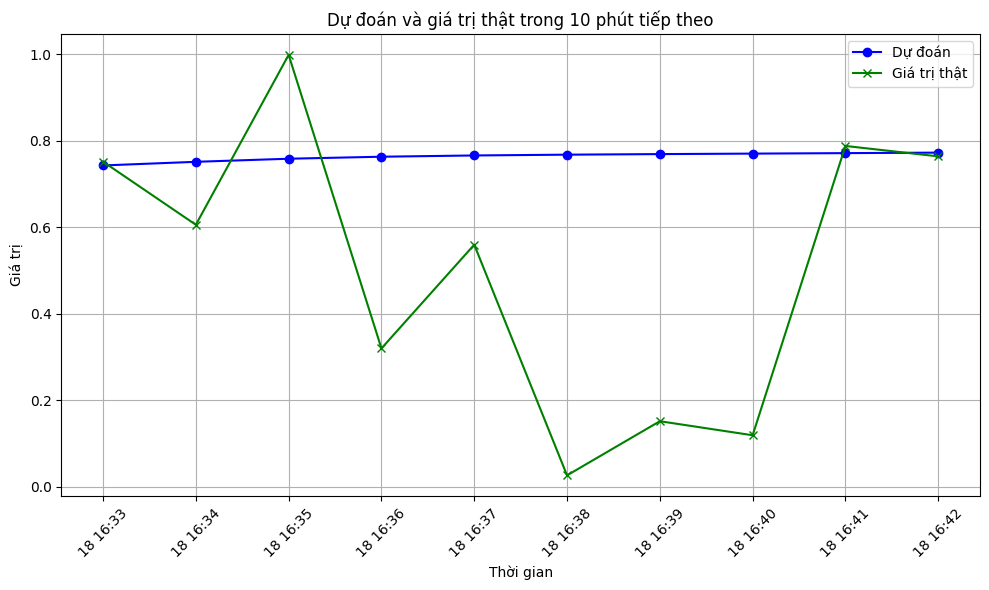

In [25]:
# Kiểm tra và xử lý index thời gian trong data
def prepare_time_index(data):
    if not isinstance(data.index, pd.DatetimeIndex):
        if 'time' in data.columns:  # Nếu có cột 'time' chứa thời gian
            data['time'] = pd.to_datetime(data['time'])  # Chuyển sang datetime
            data.set_index('time', inplace=True)  # Đặt cột 'time' làm index
        else:
            raise ValueError("DataFrame `data` không chứa thời gian hoặc không có index thời gian.")
    return data

# Hàm lấy chỉ số gần nhất cho một thời gian nhập vào
def get_test_record_by_datetime(input_datetime, time_index):
    time_diff = (time_index - input_datetime).total_seconds()  # Tính chênh lệch thời gian
    closest_time_index = np.argmin(np.abs(time_diff))  # Tìm chỉ số có sự khác biệt nhỏ nhất
    return closest_time_index

# Hàm dự đoán
def predict_future_from_last_20(data, X_test, y_test, model, scaler, num_minutes=10):
    # Chuẩn bị time index từ data
    data = prepare_time_index(data)
    time_index_test = data.index[-len(X_test):]  # Lấy index của tập X_test
    time_index_test = time_index_test.tz_localize(None)  # Loại bỏ timezone nếu có

    # Chọn dòng bắt đầu dự đoán: cách dòng cuối 20 dòng
    start_index = len(X_test) - 20
    input_datetime = time_index_test[start_index]

    # Lấy index tương ứng với thời gian nhập vào
    index_for_input = get_test_record_by_datetime(input_datetime, time_index_test)

    # Lấy X_current tương ứng với chỉ số này
    X_current = X_test[index_for_input]

    # Khởi tạo danh sách kết quả
    future_predictions = []
    actual_values = []

    # Dự đoán liên tục trong num_minutes phút
    for i in range(num_minutes):
        # Dự đoán giá trị tiếp theo
        next_pred = model.predict(X_current.reshape(1, X_current.shape[0], X_current.shape[1]), verbose=0)[0, 0]

        # Lấy giá trị thực tế từ y_test
        actual_value = y_test[index_for_input + i] if index_for_input + i < len(y_test) else None

        # Thêm giá trị dự đoán và giá trị thực tế vào danh sách
        future_predictions.append(next_pred)
        actual_values.append(actual_value if actual_value is not None else np.nan)

        # Cập nhật đầu vào cho lần dự đoán tiếp theo
        X_current = np.roll(X_current, -1, axis=0)  # Lăn dữ liệu về bên trái
        X_current[-1] = np.array([next_pred] * X_current.shape[1])  # Thay thế giá trị cuối cùng bằng dự đoán mới

    # Chuyển đổi giá trị về thang đo gốc
    def inverse_transform(values):
        values_array = np.array(values).reshape(-1, 1)
        extended_array = np.zeros((len(values), X_test.shape[2]))
        extended_array[:, 0] = values_array[:, 0]
        return scaler.inverse_transform(extended_array)[:, 0]

    # Chuyển đổi giá trị thực tế và dự đoán về thang đo gốc
    actual_values_original = inverse_transform(actual_values)
    future_predictions_original = inverse_transform(future_predictions)
    
      # Tạo DataFrame để hiển thị các giá trị dự đoán và thực tế sacaled
    future_df = pd.DataFrame({
        "Thời gian": time_index_test[start_index:start_index + num_minutes],
        "Dự đoán (Predicted)": future_predictions,
        "Giá trị thật (Actual)": actual_values,
    })

    # # Tạo DataFrame để hiển thị các giá trị dự đoán và thực tế
    # future_df = pd.DataFrame({
    #     "Thời gian": time_index_test[start_index:start_index + num_minutes],
    #     "Dự đoán (Predicted)": future_predictions_original,
    #     "Giá trị thật (Actual)": actual_values_original,
    # })

    # Hiển thị kết quả dự đoán
    print(future_df.to_string(index=False))

    # Vẽ biểu đồ kết quả
    plt.figure(figsize=(10, 6))
    plt.plot(future_df["Thời gian"], future_df["Dự đoán (Predicted)"], marker='o', label="Dự đoán", color='b')
    plt.plot(future_df["Thời gian"], future_df["Giá trị thật (Actual)"], marker='x', label="Giá trị thật", color='g')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị')
    plt.title('Dự đoán và giá trị thật trong {} phút tiếp theo'.format(num_minutes))
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Gọi hàm dự đoán
predict_future_from_last_20(data, X_test, y_test, model, scaler, num_minutes=10)

In [23]:
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
print(X_test_df.tail(20))

           0         1         2         3         4         5         6    \
1635  0.747836  0.747836  0.743340  0.745954  0.745260  0.013593  0.746142   
1636  0.120012  0.120012  0.115551  0.141098  0.141507  0.010527  0.120012   
1637  0.346645  0.346645  0.344132  0.362069  0.364642  0.021477  0.344965   
1638  0.098743  0.098743  0.100792  0.118403  0.125351  0.038911  0.095556   
1639  0.952575  0.952575  0.948344  0.953554  0.952423  0.009494  0.955452   
1640  0.103468  0.103468  0.102772  0.124560  0.129389  0.011667  0.100231   
1641  0.611817  0.611817  0.609791  0.622801  0.623244  0.012061  0.614155   
1642  0.222868  0.222868  0.221249  0.241379  0.242978  0.017288  0.218193   
1643  0.620628  0.620628  0.615954  0.628255  0.626229  0.010506  0.621743   
1644  0.613435  0.613435  0.611591  0.616115  0.620435  0.363269  0.601355   
1645  0.842165  0.842165  0.837293  0.842364  0.843048  0.012502  0.846114   
1646  0.951496  0.951496  0.952840  0.953554  0.952599  0.019719

In [22]:
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))
print(X_train_df.head(20))

         0         1         2         3         4         5         6    \
0   0.874407  0.874407  0.870411  0.878255  0.877282  0.013198  0.874346   
1   0.552297  0.552297  0.547516  0.557002  0.555896  0.031043  0.550858   
2   0.506263  0.506263  0.502880  0.519353  0.518961  0.049082  0.506802   
3   0.748660  0.748660  0.744241  0.752991  0.750703  0.006079  0.747940   
4   0.112459  0.112459  0.106911  0.122449  0.126756  0.216272  0.106195   
5   0.856914  0.856914  0.852772  0.861365  0.858849  0.005931  0.854573   
6   0.308462  0.308462  0.304536  0.322660  0.326194  0.016225  0.310620   
7   0.887840  0.887840  0.889129  0.892681  0.895892  0.012751  0.890357   
8   0.740500  0.740500  0.740101  0.747009  0.745084  0.023433  0.737690   
9   0.104547  0.104547  0.101872  0.121042  0.122542  0.032415  0.102749   
10  0.650838  0.650838  0.648668  0.659746  0.659410  0.029837  0.648500   
11  0.495179  0.495179  0.492801  0.508445  0.509133  0.011888  0.497632   
12  0.116684